# Nichesphere differential communication tutorial

Nichesphere also offers the possibility to look at localized process based differential cell - cell communication based on Ligand-Receptor pairs expression data, such as results from LIANA and CrossTalkeR(Nagai et. al., 2021). This improves the interpretability of cell communication analysis as we will find changes in biological processes related to the changes in physical cell interactions. For this tutorial, we will use our self compiled database which classifies ligands according to extracellular matrix (ECM) or immune cell recruitment related processes: https://github.com/CostaLab/Nichesphere/tree/main/nichesphere/db

## 1. Libraries and functions

In [1]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors 
import networkx as nx
import warnings
import scanpy as sc
#import leidenalg
#import sklearn
#import igraph as ig
import mudata as md
from community_layout.layout_class import CommunityLayout
warnings.filterwarnings("ignore")

import nichesphere

COMMUNITY LAYOUT: Datashader not found, edge bundling not available


## 2. Differential co-localization niches data

One of the advantages of Nichesphere is that it allows process based localized differential communication testing by looking at changes in LR interactions involved in specific processes between niches. To do this, we will need the correspondence data between cell type pairs and niche pairs, which we got from the **differential co-localization analysis**. You can check the differential co-localization tutorial for more details: https://nichesphere.readthedocs.io/en/latest/notebooks/Nichesphere_tutorial_MIvisium_coloc.html 

In [2]:
pairCatDFdir=pd.read_csv('pairCatDFdir_MIvisium_louvain.csv', index_col=0)
pairCatDFdir.head()

,cell_pairs,niche_pairs
0,Fib1_SCARA5->Fib1_SCARA5,1_Stromal->1_Stromal
1,Fib1_SCARA5->damaged_CM,1_Stromal->2_Stressed_CM
2,Fib1_SCARA5->Capillary_Endo,1_Stromal->2_Stressed_CM
3,Fib1_SCARA5->LYVE_FOLR_Macrophages,1_Stromal->2_Stressed_CM
4,Fib1_SCARA5->Fib3_C7,1_Stromal->1_Stromal


As well as cell types and niches

In [3]:
niches_df=pd.read_csv('niches_df_MIvisium_louvain.csv', index_col=0)
niches_df.head()

,cell.1,niche,color
cell,,,
Fib1_SCARA5,Fib1_SCARA5,1_Stromal,#4daf4a
damaged_CM,damaged_CM,2_Stressed_CM,#0072B5
Capillary_Endo,Capillary_Endo,2_Stressed_CM,#0072B5
LYVE_FOLR_Macrophages,LYVE_FOLR_Macrophages,2_Stressed_CM,#0072B5
Fib3_C7,Fib3_C7,1_Stromal,#4daf4a


In [4]:
niches_dict={'1_Stromal': ['Fib3_C7',
  'vCM_4',
  'Fib1_SCARA5',
  'Fib4_COL15A1',
  'Pericyte_2',
  'Pericyte_1'],
 '2_stressedCM': ['intermediate_CM',
  'damaged_CM',
  'vCM_3',
  'Mast',
  'CD_8',
  'NK_T',
  'Capillary_Endo',
  'LYVE_FOLR_Macrophages',
  'Endocardial_Endo',
  'Neuronal',
  'CD_4'],
 '3_CMimmuno': ['healthy_CM',
  'Arterial_Endo',
  'vSMCs_1',
  'Monocytes',
  'NK',
  'vSMCs_2'],
 '4_Fibrotic': ['LYVE_PLTP_Macrophages',
  'SPP1_Macrophages',
  'Venous_Endo',
  'CCL18_Macrophages',
  'Fib2_Myofib',
  'Lymphatic_Endo',
  'perivascular_fibroblasts']}

And the differential co-localization network with nodes positions, as we will look at LR interactions between differentially co-localized cell types

In [5]:
gCol=nx.read_graphml("colocNW_MIvisium_louvain.graphml")
pos=np.load('colocNW_pos.npy',allow_pickle='TRUE').item()

Same cell type interactions will be excluded later on, so we'll have a list of same cell type interaction pairs in order to subset the co-localization table we'll generate in the next step.

In [6]:
oneCTints=niches_df.index+'-'+niches_df.index

We will filter cell type pairs with non significant differential co-localization scores. Cell pairs with filter=1 will be tested

In [7]:
colocFilt=pd.read_csv('colocFilt_MIvisium_louvain.csv', index_col=0)
colocFilt

,filter
cell_pairs,
Fib1_SCARA5->Fib1_SCARA5,1.0
Fib1_SCARA5->damaged_CM,1.0
Fib1_SCARA5->Capillary_Endo,1.0
Fib1_SCARA5->LYVE_FOLR_Macrophages,0.0
Fib1_SCARA5->Fib3_C7,1.0
...,...
NK_T->vSMCs_2,0.0
NK_T->Lymphatic_Endo,0.0
NK_T->NK,0.0


## 3. Database

We are interested in cell communication related to fibrosis, so we will use a database which classifies ligands according to extracellular matrix (ECM) or immune cell recruitment related processes to look for disease related processes : 

In [8]:
allDBs=pd.read_csv('nichesphereDB_pmid.csv', index_col=0)
allDBs.head()

,Ligand,category,db,PMID
2,col1a1,Collagens,matrisome,36399478
3,col1a2,Collagens,matrisome,36399478
4,col1a1,Collagens,matrisome,36399478
5,col6a3,Collagens,matrisome,36399478
6,col1a2,Collagens,matrisome,36399478


<Axes: xlabel='count', ylabel='category'>

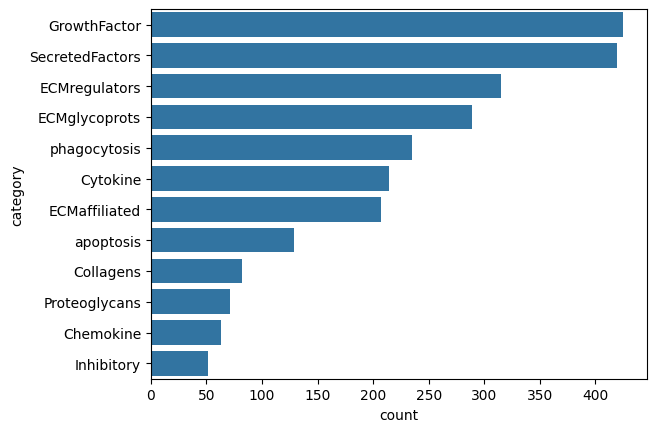

In [9]:
sns.barplot(x=allDBs.category.value_counts(), y=allDBs.category.value_counts().index,
            data=pd.DataFrame(allDBs.category.value_counts()))

Nichesphere is suited to work with CrossTalkeR output tables which contain columns called **cellpair**, indicating the cell types involved in an interaction separated by '@'; and **allpair**, indicating cell types, ligand and receptor involved. Additionally, input tables for Nichesphere should contain columns indicating the **ligand** (gene_A), **receptor** (gene_B) and **communication score** (MeanLR). The names for these last 3 columns can be indicated in Nichesphere functions.

CrossTalkeR tables contain strings indicating wether a gene is a ligand (|L), receptor (|R) or transcription factor (|TF). These strings will be removed as they might cause conflicts with code. Then we'll separate communication scores by process to know which cell type pairs and niche pairs are interacting through which processes in each condition. 

Some interactions might be present only in one condition, so we will assign 0 values to the interactions that do not appear in one condition to be able to compare conditions. After this, we get the following tables

In [10]:
myoCTpairScores_byCat2_dir_colocClusts=pd.read_csv('processed_myo_ctkr_louvainColoc.csv', index_col=0)
iscCTpairScores_byCat2_dir_colocClusts=pd.read_csv('processed_isc_ctkr_louvainColoc.csv', index_col=0)

myoCTpairScores_byCat2_dir_colocClusts.head()

,cell_pairs,niche_pairs,LRscores,LRcat,condition
allpair,,,,,
Adipo/COL14A1@Arterial_Endo/CD44,Adipo->Arterial_Endo,1_Stromal->3_Healthy_CM,0.717175,Collagens,myogenic
Adipo/COL14A1@CCL18_Macrophages/CD44,Adipo->CCL18_Macrophages,1_Stromal->4_Fibrotic,0.967985,Collagens,myogenic
Adipo/COL14A1@CD_4/CD44,Adipo->CD_4,1_Stromal->2_Stressed_CM,0.967985,Collagens,myogenic
Adipo/COL14A1@CD_8/CD44,Adipo->CD_8,1_Stromal->2_Stressed_CM,0.967985,Collagens,myogenic
Adipo/COL14A1@Fib1_SCARA5/CD44,Adipo->Fib1_SCARA5,1_Stromal->1_Stromal,0.967985,Collagens,myogenic


Names of cell types need to match between communication and co-localization data

## 4. Localized process based differential cell - cell communication 

Next, we will **filter by differential co-localization** using the **colocFilt** filtering object we created before: 

In [11]:
myoCTpairScores_byCat2_dir_colocClusts=myoCTpairScores_byCat2_dir_colocClusts[[i in colocFilt.index[colocFilt['filter']==1] for i in myoCTpairScores_byCat2_dir_colocClusts.cell_pairs]]
iscCTpairScores_byCat2_dir_colocClusts=iscCTpairScores_byCat2_dir_colocClusts[[i in colocFilt.index[colocFilt['filter']==1] for i in iscCTpairScores_byCat2_dir_colocClusts.cell_pairs]]

Then we can test for **differential cell communication** between niche pairs or cell pairs across processes with the function **diffCcommStats**. We will first test per niche pair setting the parameter **cellCatCol** to 'niche_pairs', which is the column in the tables of communication scores by process containing niche pairs:

In [12]:
myoIsc_diffCcommTable_colocGroups_dir=nichesphere.comm.diffCcommStats(c1CTpairScores_byCat=iscCTpairScores_byCat2_dir_colocClusts, 
                                                                      c2CTpairScores_byCat=myoCTpairScores_byCat2_dir_colocClusts, 
                                                                      cellCatCol='niche_pairs')
myoIsc_diffCcommTable_colocGroups_dir.head()

,wilcoxStat,wilcoxPval,cellCat,LRcat
0,11.596600,4.287770e-31,3_Healthy_CM->2_Stressed_CM,Collagens
1,7.014138,2.313703e-12,3_Healthy_CM->1_Stromal,Collagens
2,14.893355,3.640346e-50,3_Healthy_CM->3_Healthy_CM,Collagens
3,23.624021,2.183538e-123,4_Fibrotic->4_Fibrotic,Collagens
4,4.024180,5.717429e-05,4_Fibrotic->1_Stromal,Collagens


And reshape the data to plot the differential communication scores in a heatmap. Just as for the co-localization analysis, **Wilcoxon rank sums tests** are employed here. The **diffCcommStats** function returns then the table of scores per niche pair per process and the plot itself.

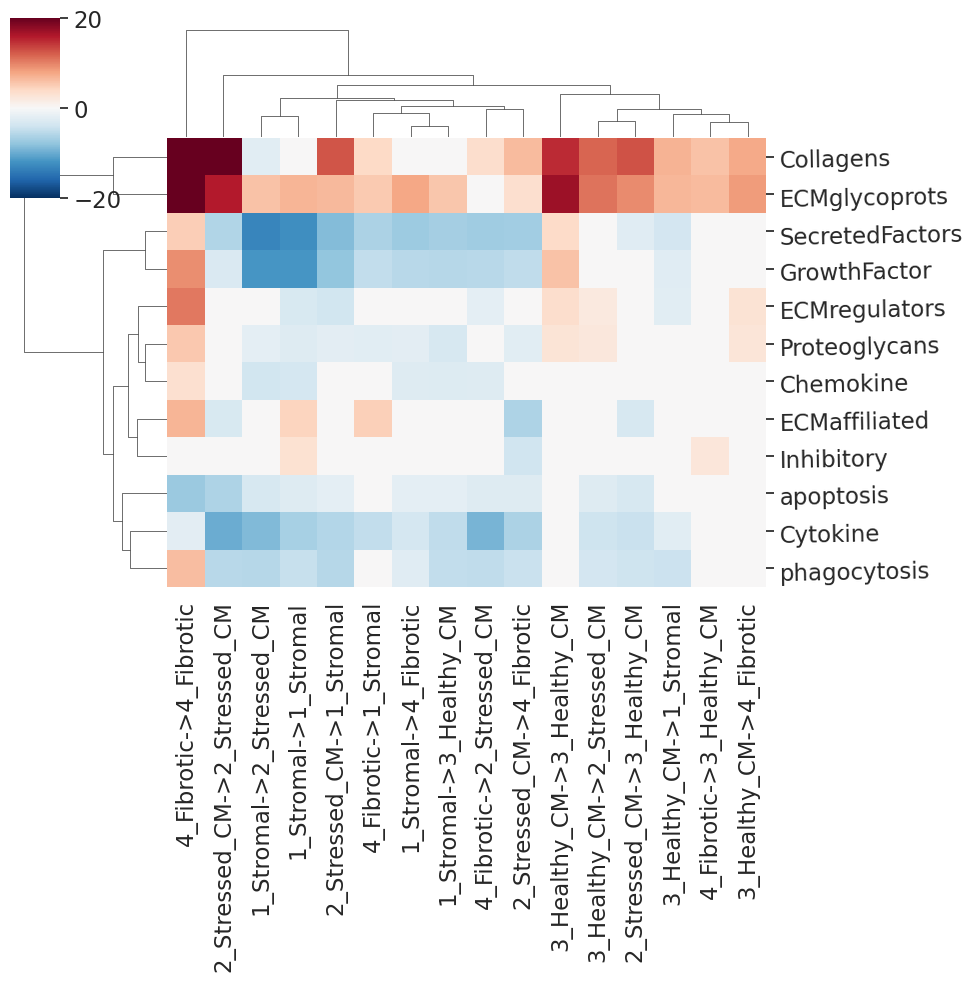

In [13]:
hm_df, cm=nichesphere.comm.plotDiffCcommStatsHM(diffCommTable=myoIsc_diffCcommTable_colocGroups_dir, 
                                                min_pval=0.05, 
                                                vmin=-20, vmax=20)

**Localized differential communication networks**

To build process specific differential cell communication networks, we will look at differential cell communication per cell type pair per process, so we will do the differential communication test again with the **diffCcommStats** function, this time setting **cellCatCol** to 'cell_pairs', which is the column in the tables of communication scores by process containing cell pairs.

In [14]:
myoIsc_diffCcommTable2_CTpair_dir=nichesphere.comm.diffCcommStats(c1CTpairScores_byCat=iscCTpairScores_byCat2_dir_colocClusts, 
                                                                  c2CTpairScores_byCat=myoCTpairScores_byCat2_dir_colocClusts, 
                                                                  cellCatCol='cell_pairs')

We must reshape the data as we will need this for the **communication networks**, and get the heatmap of differential communication scores per cell pair.

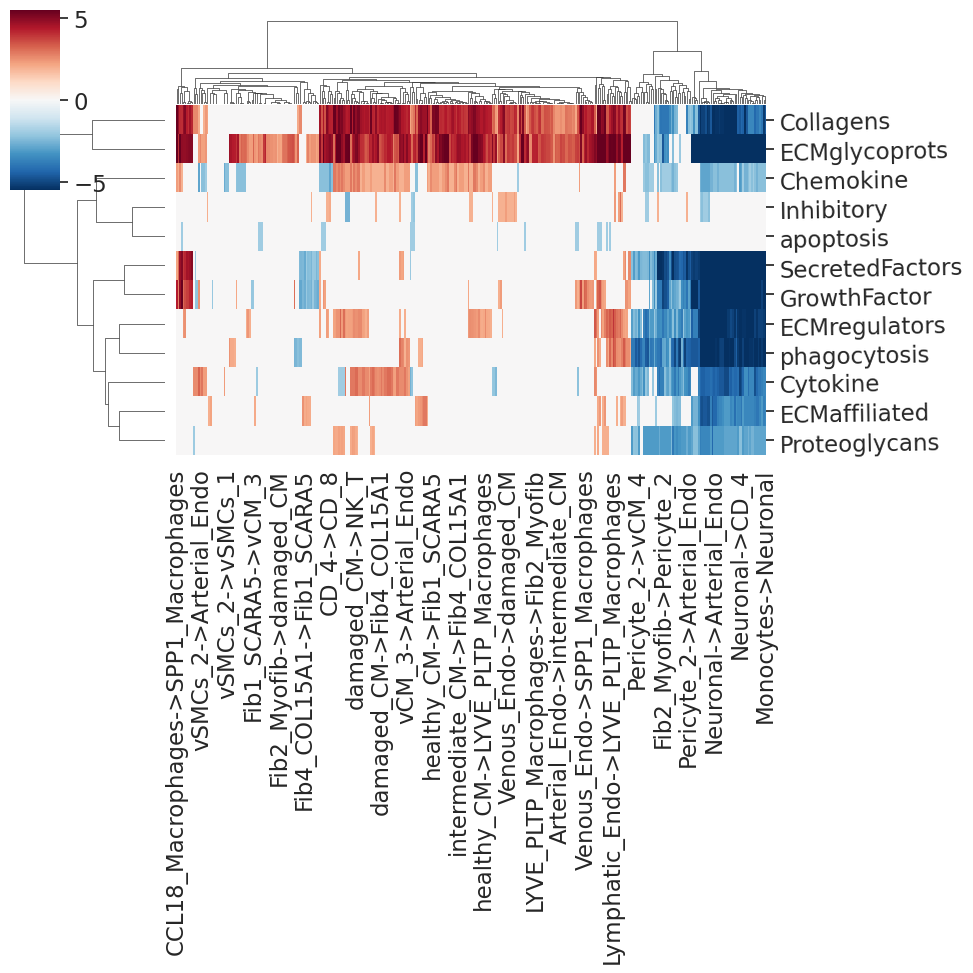

In [15]:
x_myoIsc_dir, plothm=nichesphere.comm.plotDiffCcommStatsHM(diffCommTable=myoIsc_diffCcommTable2_CTpair_dir, 
                                                           min_pval=0.05, 
                                                           vmin=-5.5, vmax=5.5)

Then we will get the **differential communication scores** for a specific **process**

In [16]:
x_chem=nichesphere.comm.getDiffComm(diffCommTbl=x_myoIsc_dir, 
                                    pairCatDF=pairCatDFdir, 
                                    ncells=33, 
                                    cat='ECMglycoprots')
x_chem.head()

,Fib1_SCARA5,damaged_CM,Capillary_Endo,LYVE_FOLR_Macrophages,Fib3_C7,healthy_CM,Fib2_Myofib,Endocardial_Endo,Arterial_Endo,Neuronal,...,CCL18_Macrophages,perivascular_fibroblasts,CD_4,vSMCs_2,Lymphatic_Endo,NK,CD_8,Purkinje_fibers,Adipo,NK_T
Fib1_SCARA5,0.000000,2.845702,2.685997,0.000000,2.291307,2.280662,2.723508,0.000000,0.000000,-7.984900,...,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
damaged_CM,3.604778,0.000000,4.424010,4.141256,4.066038,3.376389,4.209408,4.020863,4.408857,-6.539320,...,0.00000,0.0,4.756736,3.377464,0.0,0.0,4.701915,0.0,0.0,5.139999
Capillary_Endo,3.142450,3.364136,0.000000,0.000000,3.357803,3.326268,0.000000,2.268819,3.101101,-7.089490,...,0.00000,0.0,3.930870,0.000000,0.0,0.0,3.887976,0.0,0.0,0.000000
LYVE_FOLR_Macrophages,0.000000,3.584589,0.000000,0.000000,0.000000,3.055622,0.000000,0.000000,0.000000,-6.539320,...,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
Fib3_C7,2.419413,3.026513,2.898491,0.000000,0.000000,2.454029,0.000000,0.000000,2.567224,-7.890426,...,3.59563,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000


In [17]:
#Niches colors
clist=['#4daf4a', '#0072B5', '#BC3C29', '#ffff33']

And now we can **plot differential cell communication** scores per process on the edges of the co-localization network using the **catNW** function from Nichesphere, whose parameters are quite similar to the ones of the **colocMW** function

<Figure size 640x480 with 0 Axes>

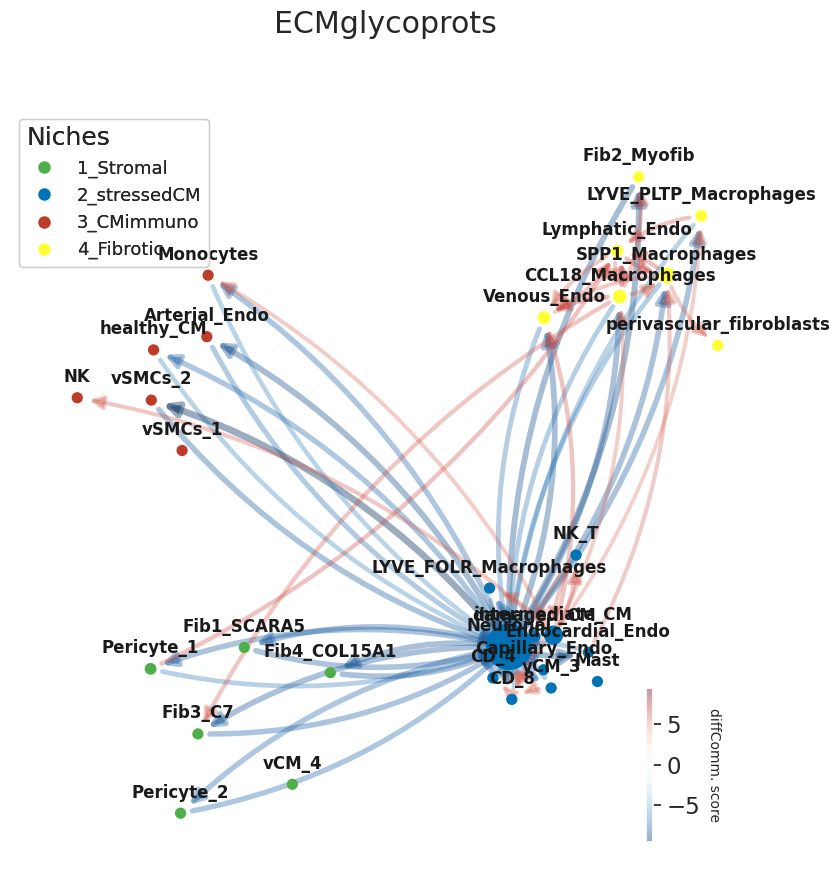

In [18]:
plt.rcParams['axes.facecolor'] = "None"
plt.figure(frameon=False)

G=nichesphere.comm.catNW(x_chem=x_chem,
                         colocNW=gCol, 
                         cell_group=niches_dict,  
                         plot_title='ECMglycoprots', 
                         clist=clist, 
                         nodeSize='betweeness', 
                         layout=None, 
                         thr=5.5,                       #only edges with weights higher than this value are shown
                         fsize=(10,10), 
                         alpha=0.4, 
                         edge_scale=0.5, 
                         pos=pos, 
                         lab_spacing=0.05)
#Legend
legend_elements1=[plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=clist[i], lw=4, 
                             label=list(niches_dict.keys())[i], ms=10) for i in range(len(list(niches_dict.keys())))]
plt.gca().add_artist(plt.legend(handles=legend_elements1,loc='upper left', fontsize=13, title='Niches', 
                                alignment='left'))
#plt.savefig('ECMglycoprots_diffCommNW.pdf')

As we did before, we will calculate some network statistics with the networkx package functions on the signed, directed differential communication network

In [19]:
t1=pd.DataFrame({'betweenness':[nx.betweenness_centrality(G)[x] for x in list(G.nodes)], 
                 #'degree':[nx.degree_centrality(G)[x] for x in list(G.nodes)], 
                 'in_degree':[nx.in_degree_centrality(G)[x] for x in list(G.nodes)],
                 'out_degree':[nx.out_degree_centrality(G)[x] for x in list(G.nodes)],
                 'pagerank':[nx.pagerank(G, weight=None)[x] for x in list(G.nodes)]})
t1.index=list(G.nodes)

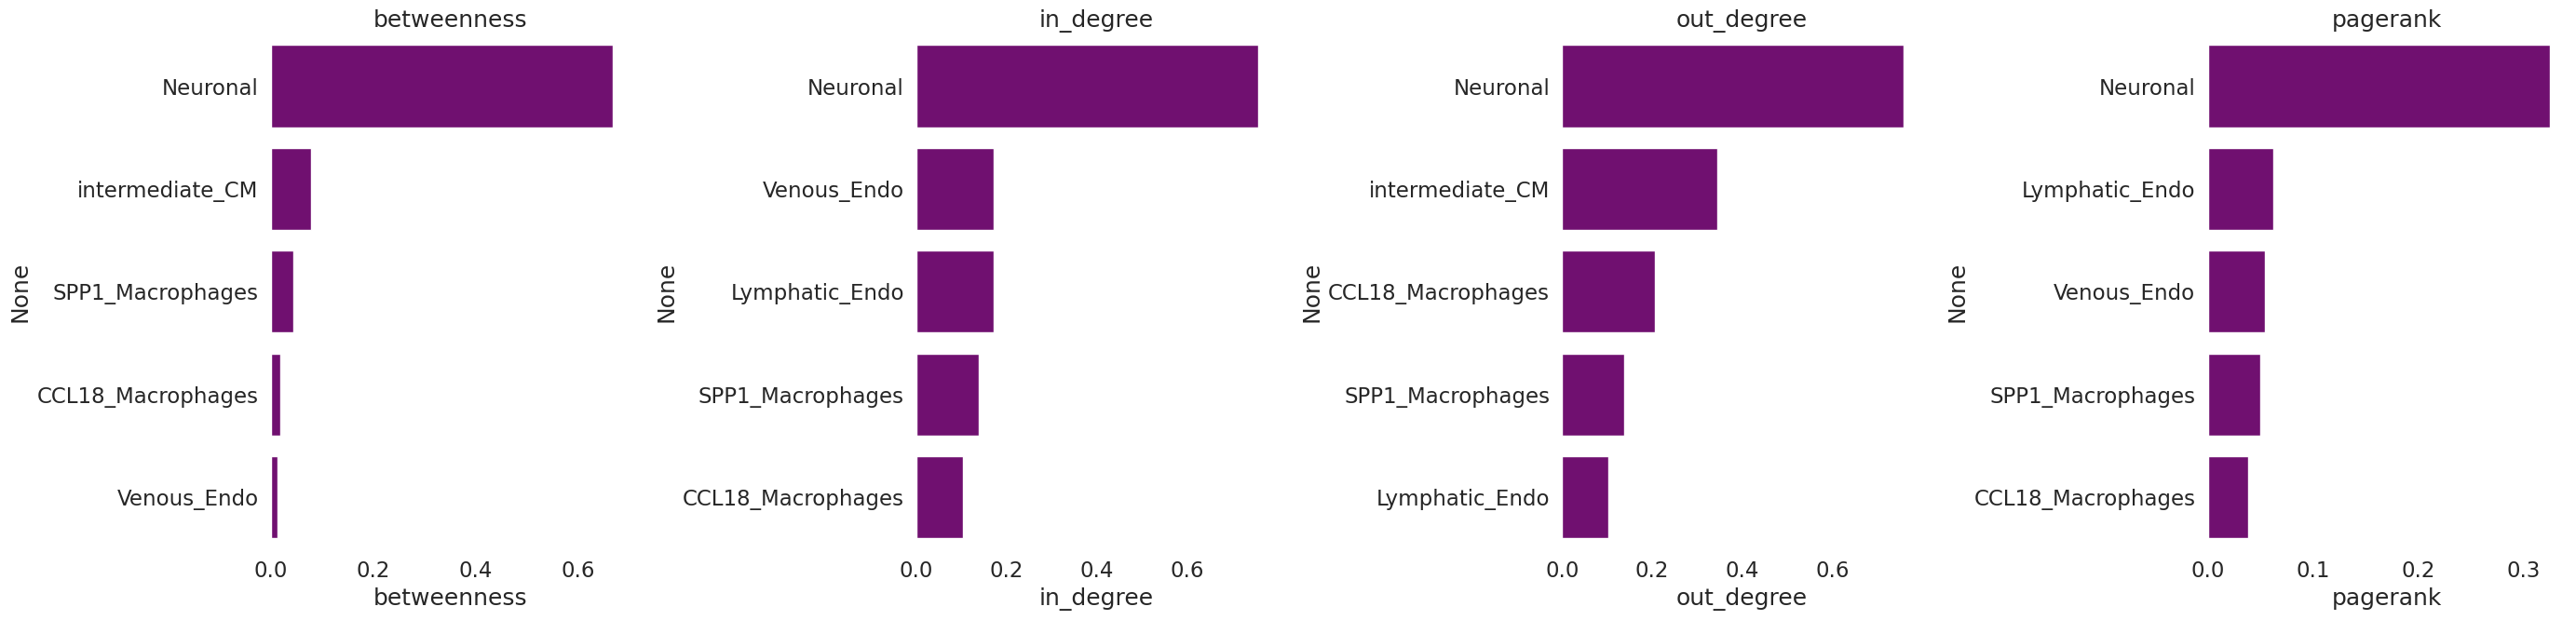

In [20]:
fig, axes = plt.subplots(1, 4, figsize=(28, 7))
for i in range(len(t1.columns)):
    _ = sns.barplot(ax=axes[i], y=t1.sort_values(t1.columns[i], ascending=False).index[0:5], x=t1.columns[i], 
        data=t1.sort_values(t1.columns[i], ascending=False)[0:5], color='purple')
    axes[i].set_title(t1.columns[i])
fig.tight_layout()

And look separately at positive and negative in and out - degree of the nodes:

In [21]:
G_pos=G.copy()
to_remove=[(a,b) for a, b, attrs in G_pos.edges(data=True) if attrs["weight"] <= 0]
G_pos.remove_edges_from(to_remove)
t1=pd.DataFrame({'in_degree':[nx.in_degree_centrality(G_pos)[x] for x in list(G_pos.nodes)],
                 'out_degree':[nx.out_degree_centrality(G_pos)[x] for x in list(G_pos.nodes)]})
t1.index=list(G_pos.nodes)

In [22]:
G_neg=G.copy()
to_remove=[(a,b) for a, b, attrs in G_neg.edges(data=True) if attrs["weight"] >= 0]
G_neg.remove_edges_from(to_remove)
t2=pd.DataFrame({'in_degree':[nx.in_degree_centrality(G_neg)[x] for x in list(G_neg.nodes)],
                 'out_degree':[nx.out_degree_centrality(G_neg)[x] for x in list(G_neg.nodes)]})
t2.index=list(G_neg.nodes)

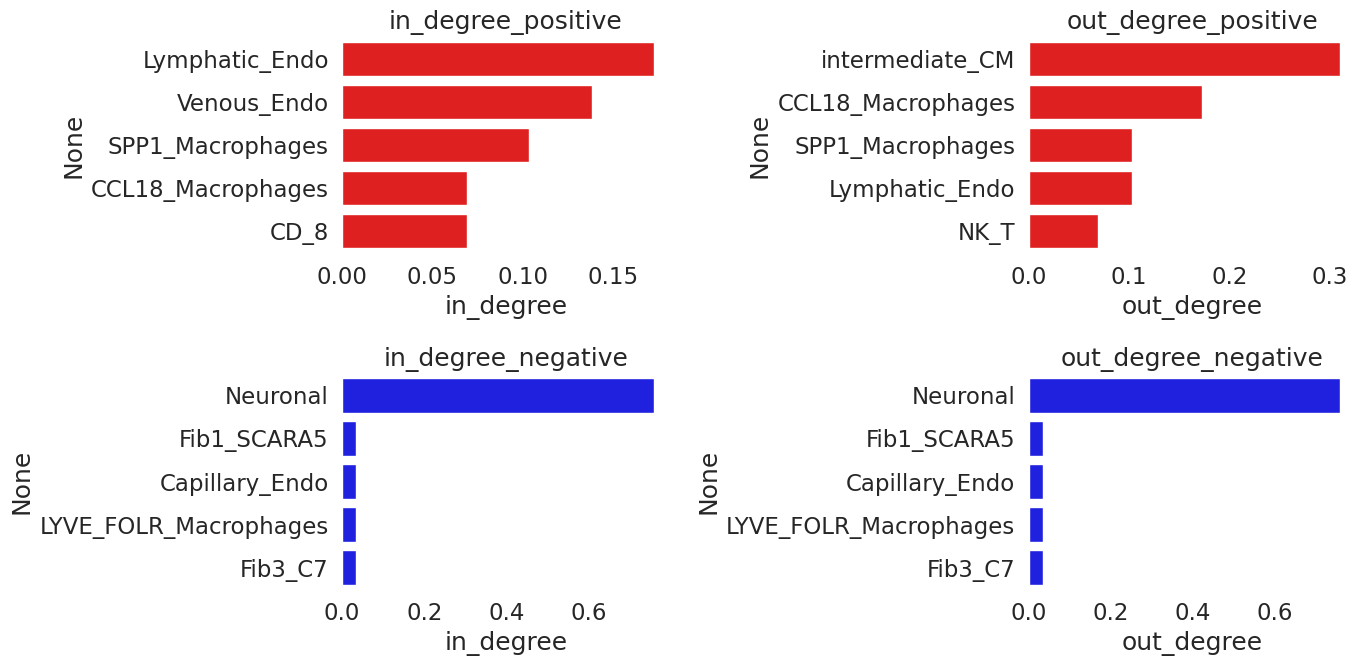

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(14, 7))
sns.barplot(ax=axes[0][0], y=t1.sort_values('in_degree', ascending=False).index[0:5], x='in_degree', 
            data=t1.sort_values('in_degree', ascending=False)[0:5], color='red')
axes[0][0].set_title('in_degree_positive')
sns.barplot(ax=axes[0][1], y=t1.sort_values('out_degree', ascending=False).index[0:5], x='out_degree', 
            data=t1.sort_values('out_degree', ascending=False)[0:5], color='red')
axes[0][1].set_title('out_degree_positive')
sns.barplot(ax=axes[1][0], y=t2.sort_values('in_degree', ascending=False).index[0:5], x='in_degree', 
            data=t2.sort_values('in_degree', ascending=False)[0:5], color='blue')
axes[1][0].set_title('in_degree_negative')
sns.barplot(ax=axes[1][1], y=t2.sort_values('out_degree', ascending=False).index[0:5], x='out_degree', 
            data=t2.sort_values('out_degree', ascending=False)[0:5], color='blue')
axes[1][1].set_title('out_degree_negative')
fig.tight_layout()